In [10]:
import numpy as np
import pandas as pd
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

In [12]:
sim_1: SimulationStudy = SimulationStudy(p=100, mean_correlation=0.8, cor_variance=0.2, n=500, no_feat_cate=3, non_linear='quadratic')
simulation_1 = sim_1.create_dataset()
#cov, mean = sim_1.get_covariance_matrix()
#cov = pd.DataFrame(cov)
#np.mean(cov.to_numpy())

In [13]:
cov, mean = sim_1.get_covariance_matrix()

In [14]:
cov = pd.DataFrame(cov)
cov.to_excel('cov.xlsx')

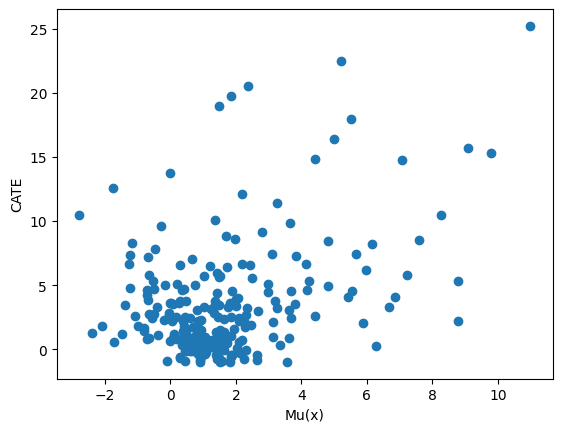

In [5]:
treated = simulation_1[simulation_1["T"] == 1]
plt.plot(treated["mu_x"], treated["CATE"], 'o')
plt.xlabel("Mu(x)")
plt.ylabel("CATE")
plt.show()

In [ ]:
x=treated[["mu_x"]]
y=treated[["CATE"]]


reg = LinearRegression().fit(x, y)
reg.score(x, y)

In [ ]:
from sympy import diff
from sympy import sin
from sympy import cos
from sympy import symbols
 

# define variable as symbol
x1 = symbols('x1')
x2 = symbols('x2')
x3 = symbols('x3')

print('The first derivative of sine is:', diff(sin(x1+x2)+x3, x1))

In [ ]:
x1 = simulation_1['X0'].to_numpy()
x2 = simulation_1['X1'].to_numpy()
x3 = simulation_1['X2'].to_numpy()

first_dev = np.cos(x1+x2+x3)

plt.plot(first_dev, x1, 'o')

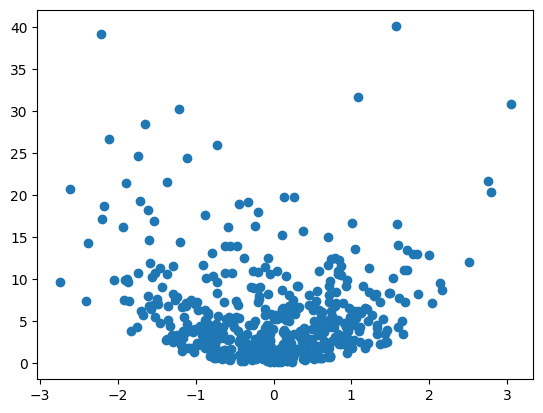

In [29]:
plt.plot(simulation_1["X0"], simulation_1['CATE'], 'o')

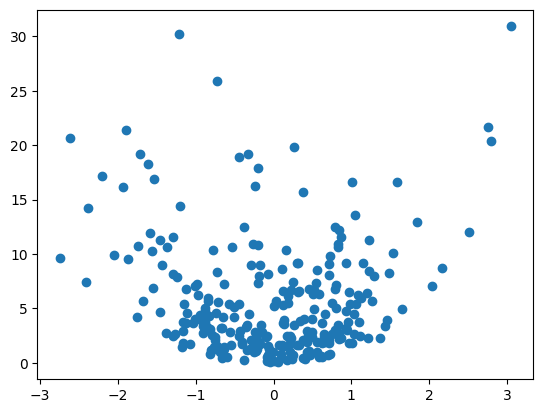

In [20]:
treated = simulation_1[simulation_1["T"] == 1]

plt.plot(treated["X0"], treated['CATE'], 'o')

#untreated = simulation_1[simulation_1["T"] == 0]
#x_var_untreat = untreated["X1"]
#plt.plot(x_var_untreat, untreated["y"], 'o')

#fit polynomial regression
#poly_fit = np.polyfit(x_var_treat, treated["CATE"], np.sin)
#poly_fit_fn = np.poly1d(poly_fit)
#plt.plot(treated["X2"], poly_fit_fn(treated["X2"]))


In [ ]:
x_var=treated[["mu_x"]]
y_var=treated[["CATE"]]


reg = LinearRegression().fit(x, y)
reg.score(x, y)

In [ ]:
plt.plot(simulation_1["CATE"], simulation_2["CATE"], 'o')

In [ ]:
x = simulation_1[['CATE']]
y = simulation_2[['CATE']]

reg = LinearRegression().fit(x, y)
reg.score(x, y)